In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

#  04. Multilayer Perceptrons
In this chapter, we will introduce your first truly deep network. The simplest deep networks are called `multilayer perceptrons`, and they consist of many layers of neurons each fully connected to those in the layer below (from which they receive input) and those above (which they, in turn, influence). When we train high-capacity models we run the risk of overfitting. Thus, we will need to provide your first rigorous introduction to the notions of `overfitting`, `underfitting`, and `capacity control`. To help you combat these problems, we will introduce regularization techniques such as `dropout` and `weight decay`. We will also discuss issues relating to numerical stability and parameter initialization that are key to successfully training deep networks. Throughout, we focus on applying models to real data, aiming to give the reader a firm grasp not just of the concepts but also of the practice of using deep networks. We punt matters relating to the computational performance, scalability and efficiency of our models to subsequent chapters.

## 4.1 Multilayer Perceptrons
In the previous chapter, we introduced softmax regression (`Section 3.4`), implementing the algorithm from scratch (`Section 3.6`) and in gluon (`Section 3.7`) and training classifiers to recognize 10 categories of clothing from low-resolution images. Along the way, we learned how to wrangle data, coerce our outputs into a valid probability distribution (via softmax), apply an appropriate loss function, and to minimize it with respect to our model's parameters. Now that we have mastered these mechanics in the context of simple linear models, we can launch our exploration of deep neural networks, the comparatively rich class of models with which this book is primarily concerned.

##### Hidden Layers
To begin, recall the model architecture corresponding to our softmax regression example, illustrated in `Fig. 4.1.1` below. This model mapped our inputs directly to our outputs via a single linear transformation:
$$ \hat{\mathbf{o}} = \mathrm{softmax}(\mathbf{W} \mathbf{x} + \mathbf{b}). $$

<img src="images/04_01.png" style="width:400px;"/>

If our labels truly were related to our input data by a linear function, then this approach would be sufficient. But linearity is a `strong assumption`.

For example, linearity implies the weaker assumption of monotonicity: that any increase in our feature must either always cause an increase in our model's output (if the corresponding weight is positive), or always always cause a decrease in our model's output (if the corresponding weight is negative). Sometimes that makes sense. For example, if we were trying to predict whether an individual will repay a loan, we might reasonably imagine that holding all else equal, an applicant with a higher income would always be more likely to repay than one with a lower income. While monotonic, this relationship likely is not linearly associated with the probability of repayment. An increase in income from 0 to 50k likely corresponds to a bigger increase in likelihood of repayment than an increase from 1M to 1.05M. One way to handle this might be to pre-process our data such that linearity becomes more plausible, say, by using the logarithm of income as our feature.

Note that we can easily come up with examples that violate `monotonicity`. Say for example that we want to predict probability of death based on body temperature. For individuals with a body temperature above 37°C (98.6°F), higher termperatures indicate greater risk. However, for individuals with body termperatures below 37° C, higher temperatures indicate lower risk! In this case too, we might resolve the problem with some clever preprocessing. Namely, we might use the distance from 37°C as our feature.

But what about classifying images of cats and dogs? Should increasing the intensity of the pixel at location (13, 17) always increase (or always decrease) the likelihood that the image depicts a dog? Reliance on a linear model corrsponds to the (implicit) assumption that the only requirement for differentiating cats vs. dogs is to assess the brightness of individual pixels. This approach is doomed to fail in a world where inverting an image preserves the category.

And yet despite the apparent absurdity of linearity here, as compared to our previous examples, it is less obvious that we could address the problem with a simple preprocessing fix. That is because the significance of any pixel depends in complex ways on its context (the values of the surrounding pixels). While there might exist a representation of our data that would take into account the relevant interactions among our features (and on top of which a linear model would be suitable), we simply do not know how to calculate it by hand. With deep neural networks, we used observational data to jointly learn both a representation (via hidden layers) and a linear predictor that acts upon that representation.

##### Incorporating Hidden Layers
We can overcome these limitations of linear models and handle a more general class of functions by incorporating one or more hidden layers. The easiest way to do this is to stack many fully-connected layers on top of each other. Each layer feeds into the layer above it, until we generate an output. We can think of the first $L-1$ layers as our representation and the final layer as our linear predictor. This architecture is commonly called a `multilayer perceptron`, often abbreviated as `MLP`. Below, we depict an `MLP` diagramtically (`Fig. 4.1.2`).

<img src="images/04_02.png" style="width:600px;"/>

This multilayer perceptron has 4 inputs, 3 outputs, and its hidden layer contains 5 hidden units. Since the input layer does not involve any calculations, producing outputs with this network requires implementing the computations for each of the 2 layers (hidden and output). Note that these layers are both fully connected. Every input influences every neuron in the hidden layer, and each of these in turn influences every neuron in the output layer.

##### From Linear to Nonlinear
Formally, we calculate each layer in this one-hidden-layer MLP as follows: 
$$ \begin{aligned} \mathbf{h} & = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1, \\ \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2, \\ \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o}). \end{aligned} $$

Note that after adding this layer, our model now requires us to track and update two additional sets of parameters. So what have we gained in exchange? You might be surprised to find out that---in the model defined above---we gain nothing for our troubles! The reason is plain. The hidden units above are given by a linear function of the inputs, and the outputs (pre-softmax) are just a linear function of the hidden units. A linear function of a linear function is itself a linear function. Moreover, our linear model was already capable of representing any linear function.

We can view the equivalence formally by proving that for any values of the weights, we can just collapse out the hidden layer, yielding an equivalent single-layer model with paramters $\mathbf{W} = \mathbf{W}_2 \mathbf{W}_1$ and $\mathbf{b} = \mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2$:

$$\mathbf{o} = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 = \mathbf{W}_2 (\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2 = (\mathbf{W}_2 \mathbf{W}_1) \mathbf{x} + (\mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2) = \mathbf{W} \mathbf{x} + \mathbf{b}.$$

In order to realize the potential of multilayer architectures, we need one more key ingredient---an elementwise nonlinear activation function $\sigma$ to be applied to each hidden unit (following the linear transformation). The most popular choice for the nonlinearity these days is the `rectified linear unit` (`ReLU`) $\mathrm{max}(x, 0)$. In general, with these activation functions in place, it is no longer possible to collapse our MLP into a linear model.

$$ \begin{aligned} \mathbf{h} & = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1), \\ \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2, \\ \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o}). \end{aligned} $$

To build more general MLPs, we can continue stacking such hidden layers, e.g., $\mathbf{h}_1 = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$ and $\mathbf{h}_2 = \sigma(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2)$, one atop another, yielding ever more expressive models (assuming fixed width).

MLPs can capture complex interactions among our inputs via their hidden neurons, which depend on the values of each of the inputs. We can easily design hidden nodes to perform arbitrary computation, for instance, basic logic operations on a pair of inputs. Moreover, for certain choices of the activation function, it is widely known that MLPs are universal approximators. Even with a single-hidden-layer network, given enough nodes (possibly absurdly many), and the right set of weights, we can model any function. Actually learning that function is the hard part. You might think of your neural network as being a bit like the C programming language. The language, like any other modern language, is capable of expressing any computable program. But actually coming up with a program that meets your specifications is the hard part.

Moreover, just because a single-layer network can learn any function does not mean that you should try to solve all of your problems with single-layer networks. In fact, we can approximate many functions much more compactly by using deeper (vs wider) networks. We will touch upon more rigorous arguments in subsequent chapters, but first let us actually build an MLP in code. In this example, we’ll implement an MLP with two hidden layers and one output layer.

##### Vectorization and Minibatch
As before, by the matrix $\mathbf{X}$, we denote a minibatch of inputs. The calculations to produce outputs from an MLP with two hidden layers can thus be expressed:

$$ \begin{aligned} \mathbf{H}_1 & = \sigma(\mathbf{W}_1 \mathbf{X} + \mathbf{b}_1), \\ \mathbf{H}_2 & = \sigma(\mathbf{W}_2 \mathbf{H}_1 + \mathbf{b}_2), \\ \mathbf{O} & = \mathrm{softmax}(\mathbf{W}_3 \mathbf{H}_2 + \mathbf{b}_3). \end{aligned} $$

With some abuse of notation, we define the nonlinearity $\sigma$ to apply to its inputs in a row-wise fashion, i.e., one observation at a time. Note that we are also using the notation for softmax in the same way to denote a row-wise operation. Often, as in this section, the activation functions that we apply to hidden layers are not merely row-wise, but component wise. That means that after computing the linear portion of the layer, we can calculate each nodes activation without looking at the values taken by the other hidden units. This is true for most activation functions (the batch normalization operation to be introduced in `Section 7.5` is a notable exception to that rule).

### 4.1.2 Activation Functions
Activation functions decide whether a neuron should be activated or not by calculating the weighted sum and further adding bias with it. They are differentiable operators to transform input signals to outputs, while most of them add non-linearity. Because activation functions are fundamental to deep learning, let us briefly survey some common activation functions.

##### ReLU Function
As stated above, the most popular choice, due to both simplicity of implementation its performance on a variety of predictive tasks is the `rectified linear unit` (`ReLU`). ReLU provides a very simple nonlinear transformation. Given the element $z$, the function is defined as the maximum of that element and 0.

$$\mathrm{ReLU}(z) = \max(z, 0).$$

Informally, the ReLU function retains only positive elements and discards all negative elements (setting the corresponding activations to 0). To gain some intuition, we can plot the function. Because it is used so commonly, `ndarray` supports the relu function as a native operator. As you can see, the activation function is piecewise linear.

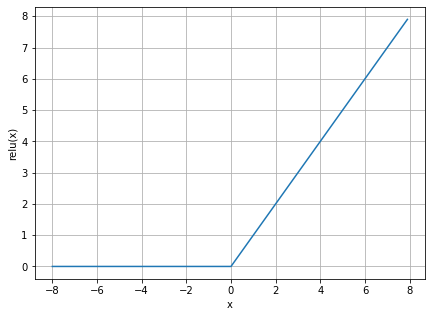

In [2]:
x = np.arange(-8.0, 8.0, 0.1)
x.attach_grad() 

with autograd.record():
    y = npx.relu(x) 

d2l.plot(x, y, 'x', 'relu(x)')

When the input is negative, the derivative of the ReLU function is 0, and when the input is positive, the derivative of the ReLU function is 1. Note that the ReLU function is not differentiable when the input takes value precisely equal to 0. In these cases, we default to the left-hand-side (LHS) derivative and say that the derivative is 0 when the input is 0. We can get away with this because the input may never actually be zero. There is an old adage that if subtle boundary conditions matter, we are probably doing (real) mathematics, not engineering. That conventional wisdom may apply here. We plot the derivative of the ReLU function plotted below.

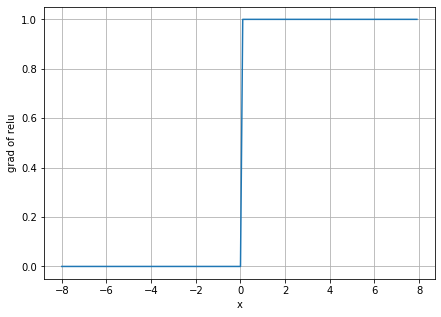

In [3]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of relu')

Note that there are many variants to the ReLU function, including the `parameterized ReLU` (`pReLU`) of He et al., 2015. This variation adds a linear term to the ReLU, so some information still gets through, even when the argument is negative.

$$\mathrm{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

The reason for using the ReLU is that its derivatives are particularly well behaved: either they vanish or they just let the argument through. This makes optimization better behaved and it mitigated the well-documented problem of vanishing gradients that plagued previous versions of neural networks (more on this later).

##### Sigmoid Function
The sigmoid function transforms its inputs, for which values lie in the domain $\mathbb{R}$, to outputs that lie on the interval $(0, 1)$. For that reason, the sigmoid is often called a squashing function: it squashes any input in the range $(-\infty, \infty)$ to some value in the range $(0, 1)$.

$$\mathrm{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists were interested in modeling biological neurons which either fire or do not fire. Thus the pioneers of this field, going all the way back to McCulloch and Pitts, the inventors of the artificial neuron, focused on thresholding units. A thresholding activation takes value $0$ when its input is below some threshold and value $1$ when the input exceeds the threshold.

When attention shifted to gradient based learning, the sigmoid function was a natural choice because it is a smooth, differentiable approximation to a thresholding unit. Sigmoids are still widely used as activation functions on the output units, when we want to interpret the outputs as probabilities for binary classification problems (you can think of the sigmoid as a special case of the softmax). However, the sigmoid has mostly been replaced by the simpler and more easily trainable ReLU for most use in hidden layers. In the `Recurrent Neural Network` chapter (`Section 8.4`), we will describe architectures that leverage sigmoid units to control the flow of information across time.

Below, we plot the sigmoid function. Note that when the input is close to 0, the sigmoid function approaches a linear transformation.

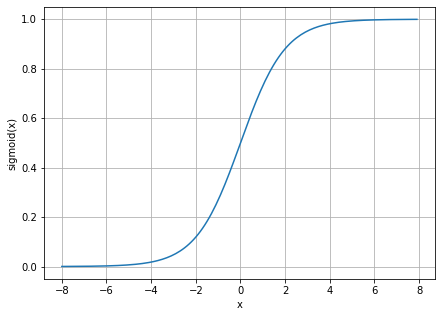

In [4]:
with autograd.record():
    y = npx.sigmoid(x)
d2l.plot(x, y, 'x', 'sigmoid(x)')

The derivative of the sigmoid function is given by the following equation:

$$\frac{d}{dx} \mathrm{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \mathrm{sigmoid}(x)\left(1-\mathrm{sigmoid}(x)\right).$$

The derivative of the sigmoid function is plotted below. Note that when the input is 0, the derivative of the sigmoid function reaches a maximum of 0.25. As the input diverges from 0 in either direction, the derivative approaches 0.

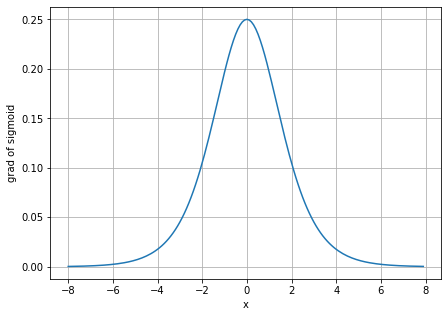

In [5]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of sigmoid')

## 4.2 Implementation of Multilayer Perceptron from Scratch
Now that we have characterized multilayer perceptrons (MLPs) mathematically, let us try to implement one ourselves.

To compare against our previous results achieved with (linear) softmax regression (`Section 3.6`), we will continue work with the `Fashion-MNIST` image classification dataset (`Section 3.5`).

In [6]:
batch_size = 256
train_iter, test_iter =d2l.load_data_fashion_mnist(batch_size)

### 4.2.1 Initializing Model Parameters
Recall that `Fashion-MNIST` contains $10$ classes, and that each image consists of a $28 \times 28 = 784$ grid of (black and white) pixel values. Again, we will disregard the spatial structure among the pixels (for now), so we can think of this as simply a classification dataset with $784$ input features and $10$ classes. To begin, we will implement an MLP with one hidden layer and $256$ hidden units. Note that we can regard both of these quantities as hyperparameters and ought in general to set them based on performance on validation data. Typically, we choose layer widths in powers of $2$, which tend to be computationally efficient because of how memory is alotted and addressed in hardware.

Again, we will represent our parameters with several `ndarrays`. Note that for every layer, we must keep track of one weight matrix and one bias vector. As always, we allocate memory for the gradients (of the loss) with respect to these parameters.

In [7]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens))
b1 = np.zeros(num_hiddens)
W2 = np.random.normal(scale=0.01, size=(num_hiddens, num_outputs))
b2 = np.zeros(num_outputs)
params = [W1, b1, W2, b2]

for param in params:
    param.attach_grad()

### 4.2.2 Activation Function
To make sure we know how everything works, we will implement the ReLU activation ourselves using the maximum function rather than invoking relu directly.

In [8]:
def relu(X):
    return np.maximum(X, 0)

### 4.2.3 The model
Because we are disregarding spatial structure, we reshape each 2D image into a flat vector of length `num_inputs`. Finally, we implement our model with just a few lines of code.

In [9]:
def net(X):
    X = X.reshape(-1, num_inputs)
    H = relu(np.dot(X, W1) + b1)
    return np.dot(H, W2) + b2

### 4.2.4 The Loss Function
To ensure numerical stability, and because we already implemented the softmax function from scratch (`Section 3.6`), we leverage `Gluon`'s integrated function for calculating the softmax and cross-entropy loss. Recall our earlier discussion of these intricacies (`Section 4.1`). We encourage the interested reader to examine the source code for loss function to deepen their knowledge of implementation details.

In [10]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

### 4.2.5 Training
Fortunately, the training loop for MLPs is exactly the same as for softmax regression. Leveraging the `d2l` package again, we call the `train_ch3` function
(see `Section 3.6`), setting the number of epochs to $10$ and the learning rate to $0.5$.

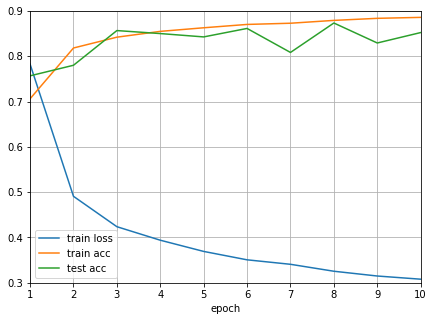

In [11]:
num_epochs, lr = 10, 0.5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, lambda batch_size: d2l.sgd(params, lr, batch_size))

To evaluate the learned model, we apply it on some test data.

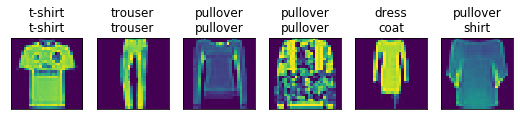

In [12]:
d2l.predict_ch3(net, test_iter)

This looks a bit better than our previous result, which used simple linear models, and it gives us some signal that we are on the right path.

##### Summary
We saw that implementing a simple MLP is easy, even when done manually. That said, with a large number of layers, this can still get messy (e.g., naming and keeping track of our model's parameters, etc).

##### Exercises
1. Change the value of the hyperparameter num_hiddens and see how this hyperparameter influences your results. Determine the best value of this hyperparameter, keeping all others constant.
2. Try adding an additional hidden layer to see how it affects the results.
3. How does changing the learning rate alter your results? Fixing the model architecture and other hyperparameters (including number of epochs), what learning rate gives you the best results?
4. What is the best result you can get by optimizing over all the parameters (learning rate, iterations, number of hidden layers, number of hidden units per layer) jointly?
5. Describe why it is much more challenging to deal with multiple hyperparameters.
6. What is the smartest strategy you can think of for structuring a search over multiple hyperparameters?


## 4.3 Concise Implementation of Multilayer Perceptron
As you might expect, by relying on the `Gluon` library, we can implement MLPs even more concisely.

### 4.3.1 The Model
As compared to our gluon implementation of softmax regression implementation (`Section 3.7`), the only difference is that we add two fully-connected layers (previously, we added one). The first is our hidden layer, which contains 256 hidden units and applies the ReLU activation function. The second is our output layer.

In [13]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'), nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

The training loop is exactly the same as when we implemented softmax regression. This modularity enables us to separate matters concerning the model architecture from orthogonal considerations.

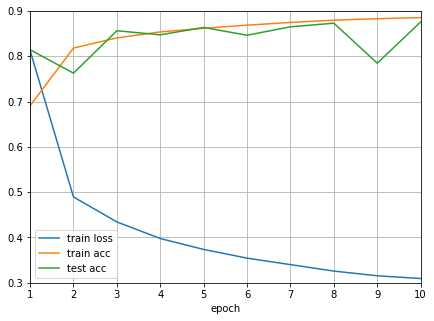

In [14]:
batch_size, num_epochs = 256, 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

##### Exercises
1. Try adding different numbers of hidden layers. What setting (keeping other parameters and hyperparameters constant) works best?
2. Try out different activation functions. Which ones work best?
3. Try different schemes for initializing the weights. What method works best?